- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


## Chapter 16 - Metric-Predicted Variable on One or Two Groups

In [107]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from scipy.stats import mode, norm, t

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

burnin = 25

In [102]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, y_labels=False, ax=None):
       
    color = '#87ceeb'
    
    if ax == None:
        ax = plt.gca()
    
    ax_mode = mode(np.round(dist, decimals=decimals))[0][0] 
    hpd_interval = np.round(pmc.hpd(dist, alpha=alpha), decimals=decimals)

    # Histogram, Mode
    sns.distplot(dist, kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    ax.text(ax_mode, plot_height*.9, 'mode = {}'.format(ax_mode),
            horizontalalignment='center', fontdict={'size':14})    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict={'size':14})
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict={'size':14})

    # Reference line
    if vert_ref is None:
        ax.axvline(ax_mode, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### Data

In [3]:
df = pd.read_csv('data/TwoGroupIQ.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Score    120 non-null int64
Group    120 non-null object
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [4]:
df.head()

   Score       Group
0    102  Smart Drug
1    107  Smart Drug
2     92  Smart Drug
3    101  Smart Drug
4    110  Smart Drug

In [5]:
# Mean and standard deviation
df.groupby('Group').agg(['mean', 'std'])

                 Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

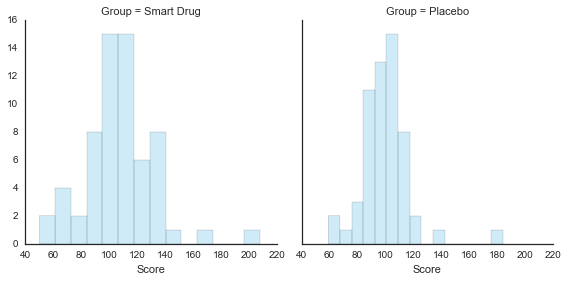

In [6]:
fg = sns.FacetGrid(df, col='Group', size=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

In [7]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model

In [8]:
with pmc.Model() as model:
    mu = pmc.Normal('mu', y.mean(), sd=y.std())
    sigma = pmc.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pmc.Normal('likelihood', mu, sd=sigma, observed=y)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [9]:
with model:
    trace = pmc.sample(10000)

Assigned NUTS to mu
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 5.2 sec

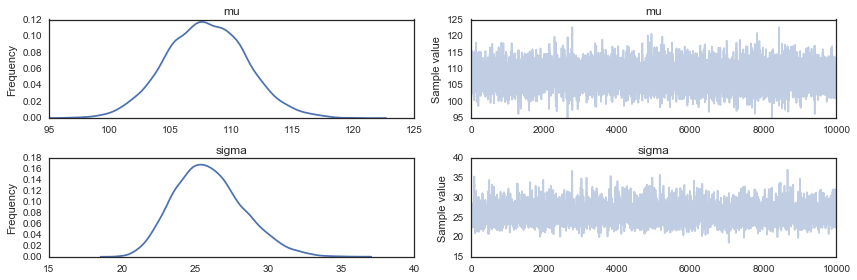

In [75]:
pmc.traceplot(trace[burnin:]);

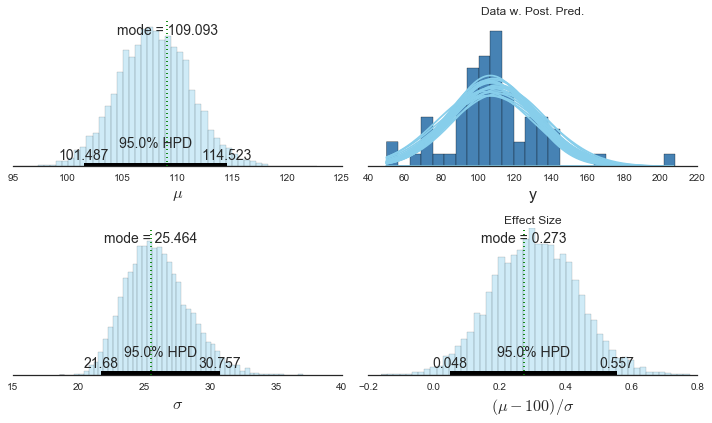

In [11]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

burnin = 25

# Upper left
plot_posterior(trace['mu'][burnin:], ax=ax1)
ax1.set_xlabel('$\mu$', fontdict={'size':16})

# Upper right
tr_len = len(trace)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
# 20 ranges in order to  
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, normed=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict={'size':16})
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
plot_posterior(trace['sigma'][burnin:], ax=ax3)
ax3.set_xlabel('$\sigma$', fontdict={'size':16})

#Lower right
plot_posterior((trace['mu'][burnin:]-100)/trace['sigma'][burnin:], ax=ax4)
ax4.set_title('Effect Size')
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict={'size':16})

plt.tight_layout();

### 16.2 - Outliers and robust estimation: the t distribution

#### Model

In [45]:
with pmc.Model() as model2:
    mu = pmc.Normal('mu', y.mean(), sd=y.std())
    sigma = pmc.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu = pmc.Exponential('nu', 1/29)
        
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pmc.StudentT('likelihood', nu,  mu, sd=sigma, observed=y)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [46]:
with model2:
    trace2 = pmc.sample(15000)

Assigned NUTS to mu
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 15000 of 15000 complete in 130.2 sec

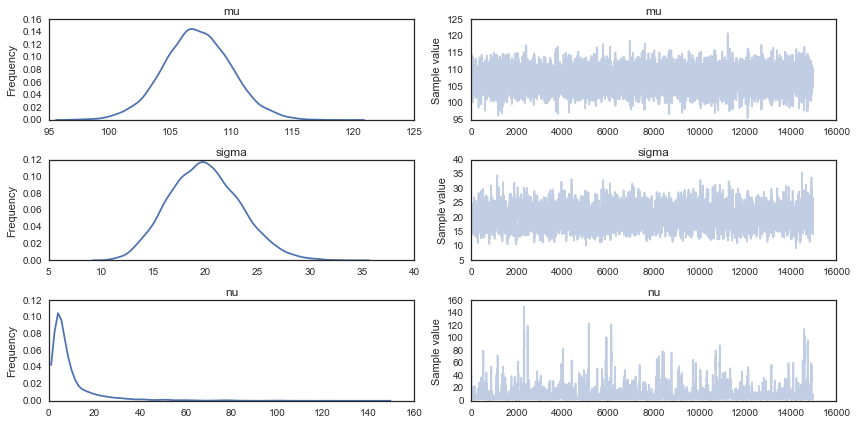

In [73]:
pmc.traceplot(trace2[burnin:]);

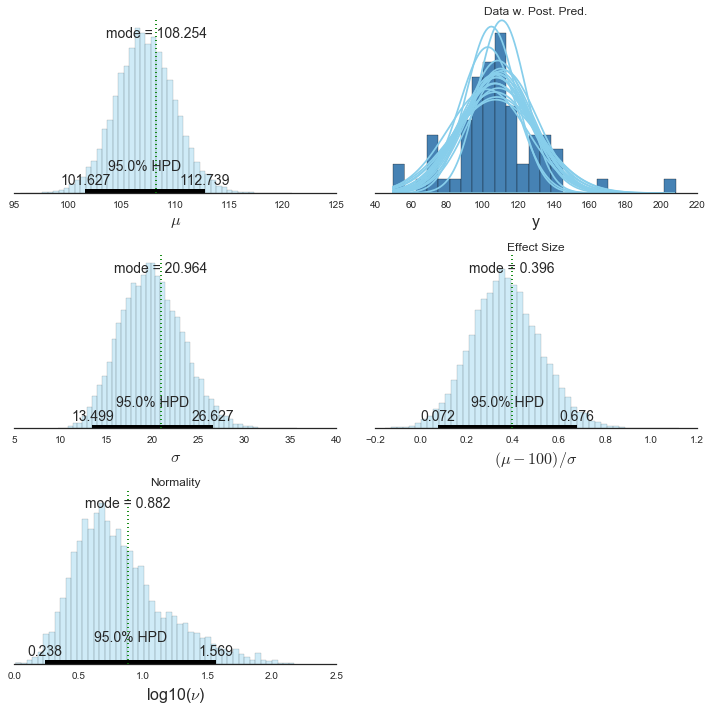

In [89]:
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(10,10))

# Upper left
plot_posterior(trace2['mu'][burnin:], ax=ax1)
ax1.set_xlabel('$\mu$', fontdict={'size':16})

# Upper right
tr_len = len(trace2)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
# 20 ranges in order to  
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, normed=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace2['mu'][stepIdxVec], trace2['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict={'size':16})
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Middle left
plot_posterior(trace2['sigma'][burnin:], ax=ax3)
ax3.set_xlabel('$\sigma$', fontdict={'size':16})

# Middle right
plot_posterior((trace2['mu'][burnin:]-100)/trace2['sigma'][burnin:], ax=ax4)
ax4.set_title('Effect Size')
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict={'size':16})

# Lower left
plot_posterior(np.log10(trace2['nu'])[burnin:], ax=ax5)
ax5.set_title('Normality')
ax5.set_xlabel(r'log10($\nu$)', fontdict={'size':16})

plt.tight_layout();
ax6.set_visible(False)

### 16.2 - Two Groups

In [127]:
le = preprocessing.LabelEncoder()

grp_idx = le.fit_transform(df.Group)
grp_codes = le.classes_
n_grps = len(le.classes_)

In [128]:
with pmc.Model() as model3:
    mu = pmc.Normal('mu', df.Score.mean(), sd=df.Score.std(), shape=n_grps)
    sigma = pmc.Uniform('sigma', df.Score.std()/1000, df.Score.std()*1000, shape=n_grps)
    nu = pmc.Exponential('nu', 1/29)
        
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pmc.StudentT('likelihood', nu,  mu[grp_idx], sd=sigma[grp_idx], observed=df.Score)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [130]:
with model3:
    trace3 = pmc.sample(15000)

Assigned NUTS to mu
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 15000 of 15000 complete in 133.1 sec

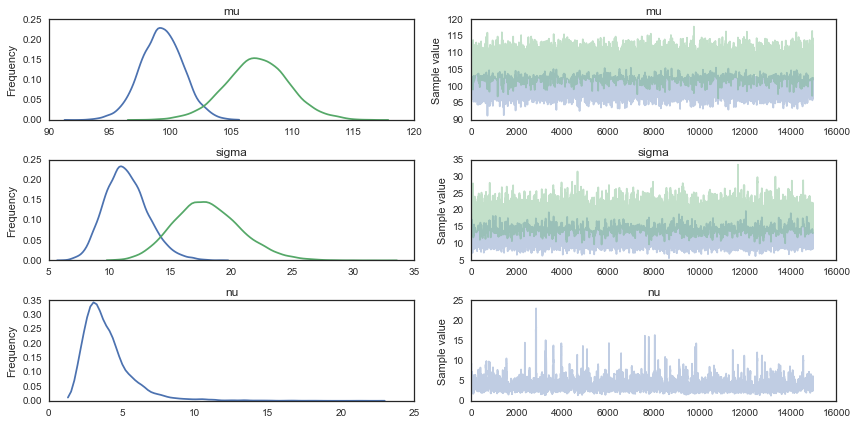

In [131]:
pmc.traceplot(trace3[burnin:]);

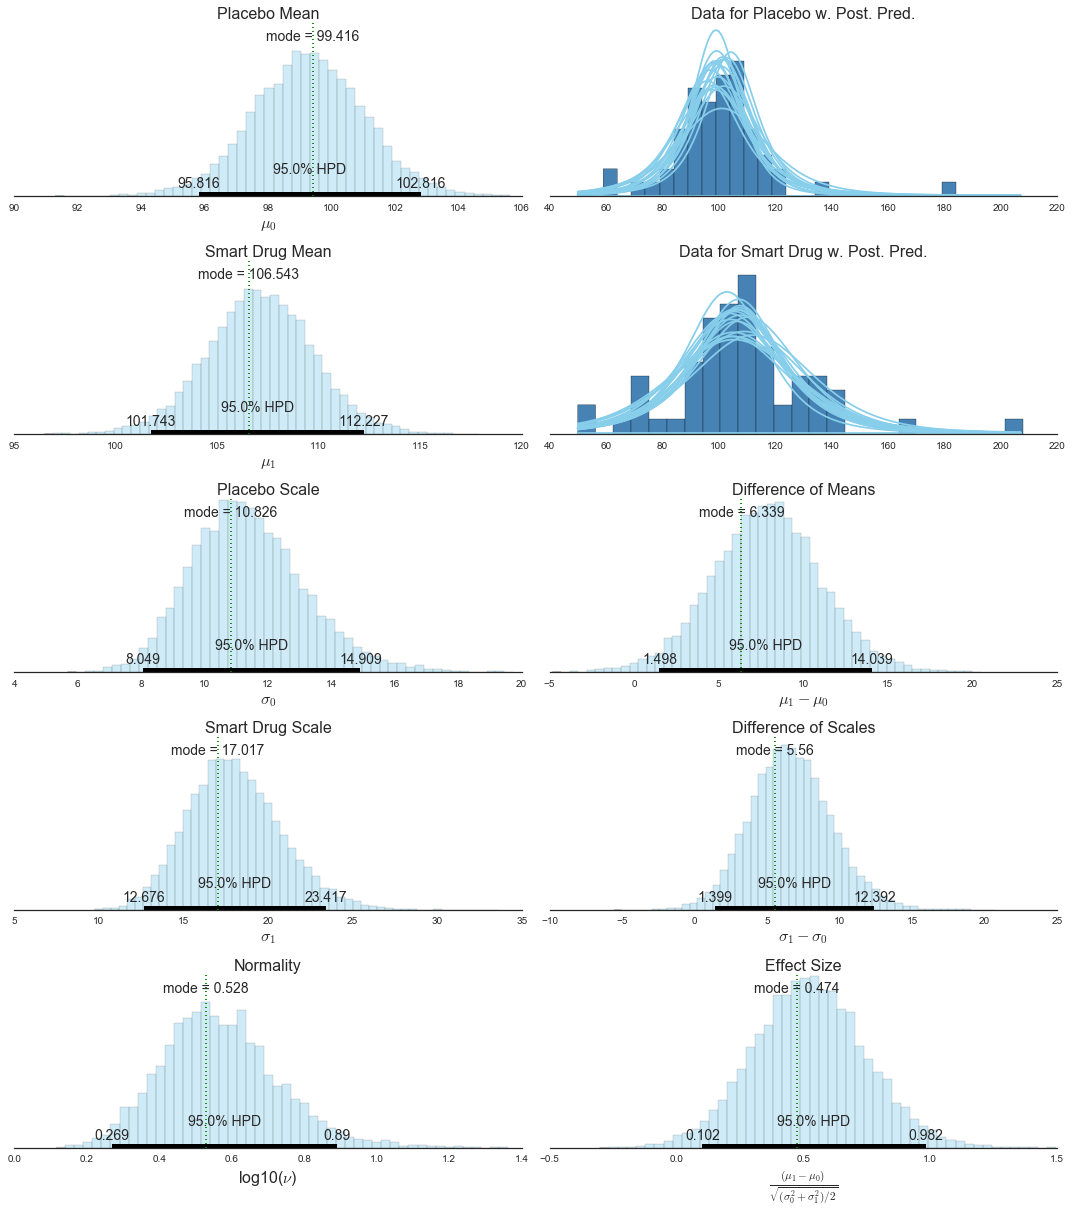

In [132]:
tr3_mu0 = trace3['mu'][:,0]
tr3_mu1 = trace3['mu'][:,1]
tr3_sigma0 = trace3['sigma'][:,0]
tr3_sigma1 = trace3['sigma'][:,1]

fig, axes = plt.subplots(5,2, figsize=(15, 17))

plot_posterior(trace3['mu'][:,0][burnin:], ax=axes[0,0])
axes[0,0].set_xlabel('$\mu_0$', fontdict={'size':16})
axes[0,0].set_title('Placebo Mean', fontdict={'size':16})

plot_posterior(trace3['mu'][:,1][burnin:], ax=axes[1,0])
axes[1,0].set_xlabel('$\mu_1$', fontdict={'size':16})
axes[1,0].set_title('Smart Drug Mean', fontdict={'size':16})

plot_posterior(trace3['sigma'][:,0][burnin:], ax=axes[2,0])
axes[2,0].set_xlabel('$\sigma_0$', fontdict={'size':16})
axes[2,0].set_title('Placebo Scale', fontdict={'size':16})

plot_posterior(trace3['sigma'][:,1][burnin:], ax=axes[3,0])
axes[3,0].set_xlabel('$\sigma_1$', fontdict={'size':16})
axes[3,0].set_title('Smart Drug Scale', fontdict={'size':16})

plot_posterior(np.log10(trace3['nu'])[burnin:], ax=axes[4,0])
axes[4,0].set_xlabel(r'log10($\nu$)', fontdict={'size':16})
axes[4,0].set_title('Normality', fontdict={'size':16})

tr_len = len(trace3)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1,1), (1,20))
axes[0,1].hist(df.Score[df.Group == 'Placebo'], bins=25, normed=True, color='steelblue')
axes[0,1].plot(x, t.pdf(x, loc=tr3_mu0[stepIdxVec], scale=tr3_sigma0[stepIdxVec], df=trace3['nu'][stepIdxVec]), c='#87ceeb')
#axes[0,1].set_xlabel('y', fontdict={'size':16})
#axes[0,1].set_title('Data w. Post. Pred.')
[axes[0,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Data for Placebo w. Post. Pred.', fontdict={'size':16})

axes[1,1].hist(df.Score[df.Group == 'Smart Drug'], bins=25, normed=True, color='steelblue')
axes[1,1].plot(x, t.pdf(x, loc=tr3_mu1[stepIdxVec], scale=tr3_sigma1[stepIdxVec], df=trace3['nu'][stepIdxVec]), c='#87ceeb')
#axes[0,1].set_xlabel('y', fontdict={'size':16})
#axes[0,1].set_title('Data w. Post. Pred.')
[axes[1,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('Data for Smart Drug w. Post. Pred.', fontdict={'size':16})

plot_posterior((tr3_mu1-tr3_mu0)[burnin:], ax=axes[2,1])
axes[2,1].set_xlabel('$\mu_1 - \mu_0$', fontdict={'size':16})
axes[2,1].set_title('Difference of Means', fontdict={'size':16})

plot_posterior((tr3_sigma1-tr3_sigma0)[burnin:], ax=axes[3,1])
axes[3,1].set_xlabel('$\sigma_1 - \sigma_0$', fontdict={'size':16})
axes[3,1].set_title('Difference of Scales', fontdict={'size':16})

plot_posterior((tr3_mu1-tr3_mu0)/np.sqrt((tr3_sigma0**2+tr3_sigma1**2)/2), ax=axes[4,1])
axes[4,1].set_xlabel(r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$', fontdict={'size':16})
axes[4,1].set_title('Effect Size', fontdict={'size':16})

plt.tight_layout();